In [37]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.multioutput import MultiOutputRegressor
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from sklearn import model_selection
from keras.wrappers.scikit_learn import KerasRegressor
import pandas as pd

layerArray       = [2, 3, 4, 5, 6]
neuronArray      = [16, 32, 64, 128 ,256, 512, 1024]
markers          = ['o', 'D', 'x', 'P', '<']
gainArray        = []
lossArray        = []
gainDistribution = []
lossDistribution = []
strategyArray    = []
ampNumber        = 4

originalDataSet = pd.read_csv('dataset.txt', sep = ',',header = None)
binaryDataSet   = []

for line in originalDataSet.values:
    myList = [1 if i != 0 else 0 for i in line[:40]]
    myList.extend(line[40:])
    binaryDataSet.append(myList)

binaryDataSet = pd.DataFrame(binaryDataSet)
gainScaler    = MinMaxScaler(feature_range = (-1, 1))
lossScaler    = MinMaxScaler(feature_range = (-1, 1))

gainScalerAux = []
lossScalerAux = []

for i in range(0, ampNumber * 2, 2):
    gainScalerAux.extend(binaryDataSet.values[:, 40 + i])
    lossScalerAux.extend(binaryDataSet.values[:, 40 + i + 1])

gainScaler.fit(np.array(gainScalerAux).reshape(-1, 1))
lossScaler.fit(np.array(lossScalerAux).reshape(-1, 1))

def loadDataset(): 
    dataSet = binaryDataSet.values[:, :40]
    
    for i in range(0, ampNumber * 2, 2):
        gain    = np.array(binaryDataSet.values[:, 40 + i])
        gain    = gainScaler.transform(gain.reshape(-1, 1))
        dataSet = np.hstack((dataSet, gain))
        
        loss    = np.array(binaryDataSet.values[:, 40 + i + 1])
        loss    = lossScaler.transform(gain.reshape(-1, 1))
        dataSet = np.hstack((dataSet, loss))
            
    features, result = np.array(dataSet[:, :40]), np.array(dataSet[:, 40:])
    return features, result

def invertGainNorm(value):
    auxArray = np.array([value, 0, 0, 0, 0, 0]).reshape(-1, 1)
    return gainScaler.inverse_transform(auxArray)[0][0]

def invertLossNorm(value):
    auxArray = np.array([value, 0, 0, 0, 0, 0]).reshape(-1, 1)
    return lossScaler.inverse_transform(auxArray)[0][0]
    
def getGainError(value1, value2):
    return abs(invertGainNorm(value1) - invertGainNorm(value2))

def getLossError(value1, value2):
    return abs(invertLossNorm(value1) - invertLossNorm(value2))

features, result = loadDataset()

originalDataSet = pd.read_csv('dataset.txt', sep = ',',header = None)
binaryDataSet   = []

for line in originalDataSet.values:
    myList = [1 if i != 0 else 0 for i in line[:40]]
    myList.extend(line[40:])
    binaryDataSet.append(myList)

binaryDataSet = pd.DataFrame(binaryDataSet)
gainScaler    = MinMaxScaler(feature_range = (-1, 1))
lossScaler    = MinMaxScaler(feature_range = (-1, 1))

gainScalerAux = []
lossScalerAux = []

for i in range(0, ampNumber * 2, 2):
    gainScalerAux.extend(binaryDataSet.values[:, 40 + i])
    lossScalerAux.extend(binaryDataSet.values[:, 40 + i + 1])

gainScaler.fit(np.array(gainScalerAux).reshape(-1, 1))
lossScaler.fit(np.array(lossScalerAux).reshape(-1, 1))

def loadDataset(): 
    dataSet = binaryDataSet.values[:, :40]
    
    for i in range(0, ampNumber * 2, 2):
        gain    = np.array(binaryDataSet.values[:, 40 + i])
        gain    = gainScaler.transform(gain.reshape(-1, 1))
        dataSet = np.hstack((dataSet, gain))
        
        loss    = np.array(binaryDataSet.values[:, 40 + i + 1])
        loss    = lossScaler.transform(loss.reshape(-1, 1))
        dataSet = np.hstack((dataSet, loss))
    
    features, result = np.array(dataSet[:, :40]), np.array(dataSet[:, 40:])
    return features, result

def invertGainNorm(value):
    auxArray = np.array([value, 0, 0, 0, 0, 0]).reshape(-1, 1)
    return gainScaler.inverse_transform(auxArray)[0][0]

def invertLossNorm(value):
    auxArray = np.array([value, 0, 0, 0, 0, 0]).reshape(-1, 1)
    return lossScaler.inverse_transform(auxArray)[0][0]
    
def getGainError(value1, value2):
    return abs(invertGainNorm(value1) - invertGainNorm(value2))

def getLossError(value1, value2):
    return abs(invertLossNorm(value1) - invertLossNorm(value2))

features, result = loadDataset()

# Setup

In [2]:
def setMLP(layers, neuronNumber):
    return MLPRegressor(hidden_layer_sizes = [neuronNumber] * layers, activation = 'identity', learning_rate = 'constant', alpha = 0.001, random_state = 0, verbose = False)

def getLoss(strategy):
    features, result = loadDataset()
    
    trainSizes, trainScores, testScores = model_selection.learning_curve(strategy, 
                                                                   features, 
                                                                   result,
                                                                   cv = 5,
                                                                   train_sizes = [math.ceil(features.shape[0] / 5)],
                                                                   scoring = 'neg_mean_squared_error')
    
    trainScores = [x * -1 for x in trainScores]
    testScores = [x * -1 for x in testScores]
    
    return np.sqrt(trainScores), np.sqrt(testScores)

# Plotting function

In [44]:
def plotTrainError(trainErrors):
    fig, axis = plt.subplots(figsize = (10, 8))
    
    for i in range(len(layerArray)):
        axis.plot(neuronArray, trainErrors[i])
        axis.scatter(neuronArray, trainErrors[i], marker = markers[i])
    
    axis.set_ylabel("RMSE (dB)", fontsize = 14)
    axis.set_xlabel("Number of neurons in each hidden layer", fontsize = 14)
    axis.legend(["{} layers".format(x) for x in layerArray])  

# Putting all together

In [4]:
trainErrors = []

for layerNumber in layerArray:
    aux = []
    for neuronNumber in neuronArray:
        print("{} layers - {} neurons".format(layerNumber, neuronNumber))
        
        regressor             = setMLP(layerNumber, neuronNumber)
        trainError, testError = getLoss(regressor)

        aux.append(np.mean(trainError[0]))
    trainErrors.append(aux)
print(trainErrors)

2 layers - 16 neurons
2 layers - 32 neurons
2 layers - 64 neurons
2 layers - 128 neurons
2 layers - 256 neurons
2 layers - 512 neurons
2 layers - 1024 neurons
3 layers - 16 neurons
3 layers - 32 neurons
3 layers - 64 neurons
3 layers - 128 neurons
3 layers - 256 neurons
3 layers - 512 neurons
3 layers - 1024 neurons
4 layers - 16 neurons
4 layers - 32 neurons
4 layers - 64 neurons
4 layers - 128 neurons
4 layers - 256 neurons
4 layers - 512 neurons
4 layers - 1024 neurons
5 layers - 16 neurons
5 layers - 32 neurons
5 layers - 64 neurons
5 layers - 128 neurons
5 layers - 256 neurons
5 layers - 512 neurons
5 layers - 1024 neurons
6 layers - 16 neurons
6 layers - 32 neurons
6 layers - 64 neurons
6 layers - 128 neurons
6 layers - 256 neurons
6 layers - 512 neurons
6 layers - 1024 neurons
[[0.3879297813838321, 0.37591790131816916, 0.3751638825357785, 0.37501258444599417, 0.37493941857411406, 0.37774548534560787, 0.37741250091151224], [0.38163162783165383, 0.37564412410320114, 0.374785600004

# Plotting graph

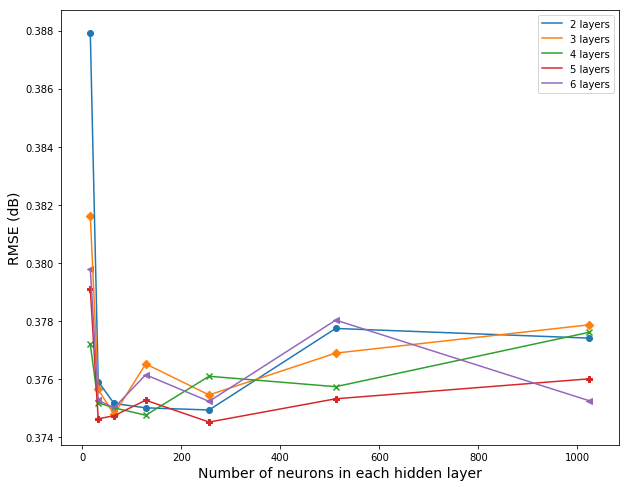

In [45]:
plotTrainError(trainErrors)